2026-01-15 21:30:55.559 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:55.560 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:55.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:55.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:55.564 No runtime found, using MemoryCacheStorageManager
2026-01-15 21:30:55.567 No runtime found, using MemoryCacheStorageManager
2026-01-15 21:30:55.569 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
[*********************100%***********************]  1 of 1 completed


signal
NEUTRAL    4627
SELL       1131
BUY         596
Name: count, dtype: int64
Nombre de trades générés: 3731
Nombre de trades générés: 3731


2026-01-15 21:30:56.281 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
[*********************100%***********************]  1 of 1 completed


signal
NEUTRAL    4851
SELL       1273
BUY         411
Name: count, dtype: int64
Nombre de trades générés: 3865
Nombre de trades générés: 3865


2026-01-15 21:30:57.025 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:57.026 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:57.027 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:57.029 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:57.029 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:57.030 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:57.030 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-15 21:30:57.031 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

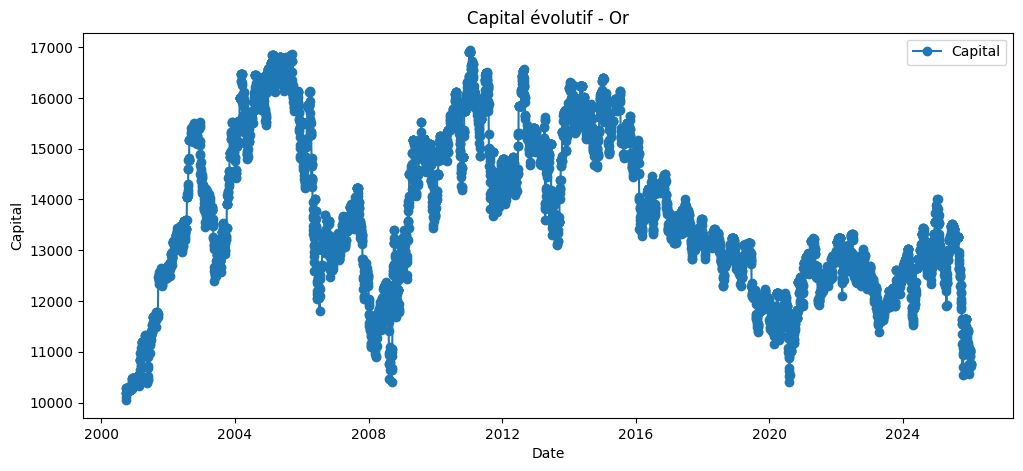

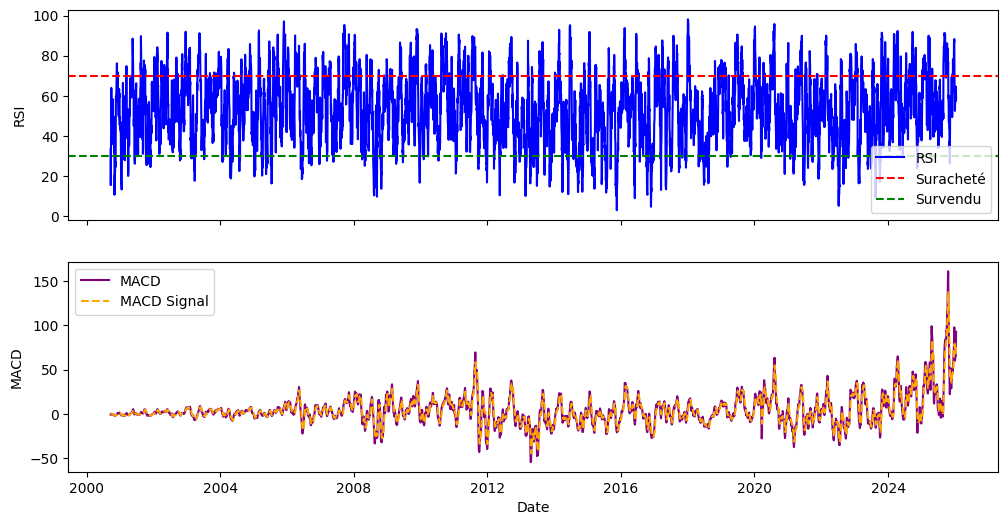

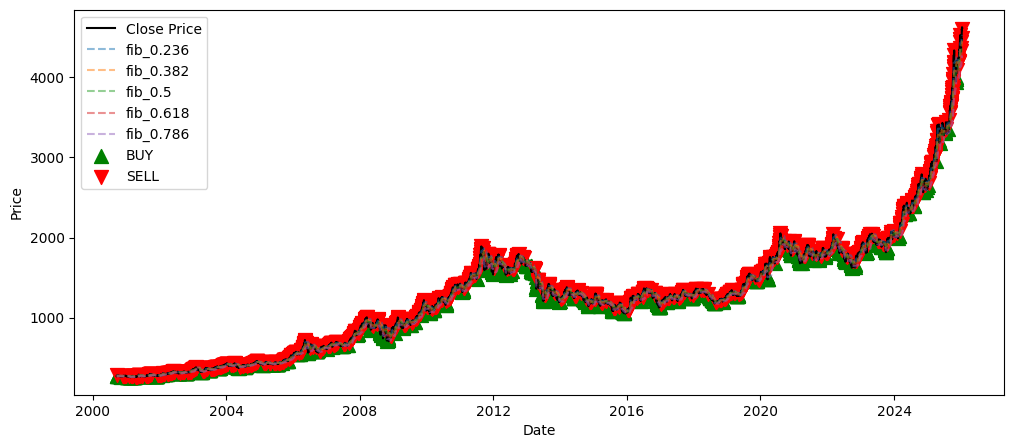

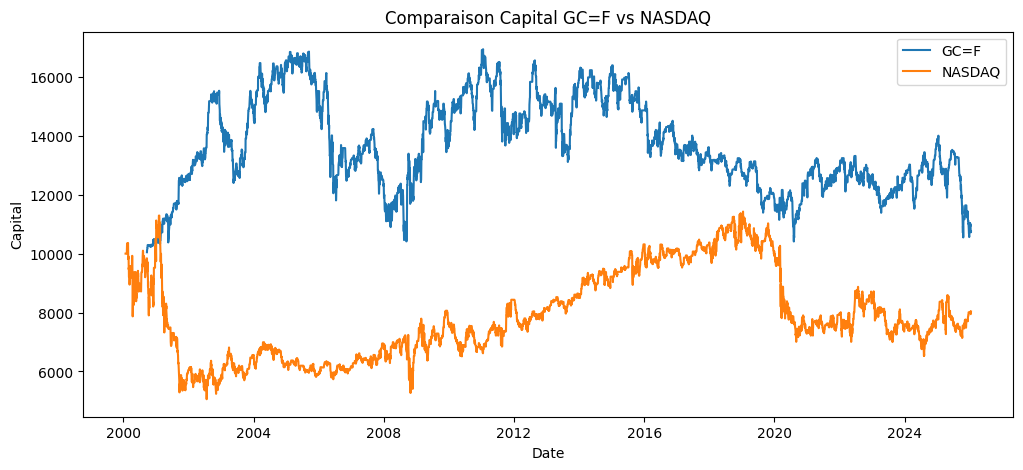

In [9]:
# dashboard_colab.py
# Streamlit dashboard pour pipeline Trading GC=F et NASDAQ (Colab)

!pip install --quiet streamlit

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from step1_pipeline import run_pipeline

st.set_page_config(page_title="Dashboard Trading", layout="wide")
st.title("📊 Dashboard Trading : GC=F et NASDAQ")

# ---------------------------- Helper ----------------------------
def ensure_date_column(df):
    """Assure que le DataFrame a une colonne 'Date' utilisable"""
    if 'Date' not in df.columns:
        df = df.reset_index()  # met l'index dans la colonne
        df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

@st.cache_data(show_spinner=True)
def load_pipeline(symbol):
    """Exécute le pipeline et retourne df et trades"""
    df, trades = run_pipeline(symbol)
    df = ensure_date_column(df)
    trades = ensure_date_column(trades)
    return df, trades

# ---------------------------- Chargement données ----------------------------
symbols = {"GC=F": "Or", "^IXIC": "NASDAQ"}
results = {}
for sym in symbols:
    df, trades = load_pipeline(sym)
    results[sym] = {"df": df, "trades": trades}
    # Export CSV
    df.to_csv(f'trades_{sym.replace("^","").replace("=","")}.csv', index=False)
    trades.to_csv(f'trades_{sym.replace("^","").replace("=","")}_trades.csv', index=False)

# ---------------------------- Sélection marché ----------------------------
market = st.selectbox("Sélectionner le marché", list(symbols.keys()))
df = results[market]["df"]
trades = results[market]["trades"]

st.subheader(f"Tableau des trades : {symbols[market]}")
st.dataframe(trades)

# ---------------------------- Graphique Capital / Equity Curve ----------------------------
st.subheader("💰 Capital / Equity Curve")
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df['Date'], df['capital'], marker='o', label='Capital')
ax.set_xlabel('Date')
ax.set_ylabel('Capital')
ax.set_title(f'Capital évolutif - {symbols[market]}')
ax.legend()
st.pyplot(fig)

# ---------------------------- Graphique RSI et MACD ----------------------------
st.subheader("📈 RSI et MACD")
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
# RSI
ax[0].plot(df['Date'], df['rsi'], color='blue', label='RSI')
ax[0].axhline(70, color='r', linestyle='--', label='Suracheté')
ax[0].axhline(30, color='g', linestyle='--', label='Survendu')
ax[0].set_ylabel('RSI')
ax[0].legend()
# MACD
ax[1].plot(df['Date'], df['macd'], color='purple', label='MACD')
ax[1].plot(df['Date'], df['macd_signal'], color='orange', linestyle='--', label='MACD Signal')
ax[1].set_ylabel('MACD')
ax[1].legend()
ax[1].set_xlabel('Date')
st.pyplot(fig)

# ---------------------------- Graphique Close + Fibonacci + Signals ----------------------------
st.subheader("📊 Close + Fibonacci + Signals")
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df['Date'], df['Close'], label='Close Price', color='black')
# Fibonacci
for level in ['fib_0.236','fib_0.382','fib_0.5','fib_0.618','fib_0.786']:
    if level in df.columns:
        ax.plot(df['Date'], df[level], linestyle='--', alpha=0.5, label=level)
# BUY / SELL
buys = df[df['signal']=='BUY']
sells = df[df['signal']=='SELL']
ax.scatter(buys['Date'], buys['Close'], marker='^', color='green', s=100, label='BUY')
ax.scatter(sells['Date'], sells['Close'], marker='v', color='red', s=100, label='SELL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
st.pyplot(fig)

# ---------------------------- Comparaison GC vs NASDAQ ----------------------------
st.subheader("⚖️ Comparaison Capital GC=F vs NASDAQ")
df_gc = results["GC=F"]["df"]
df_nasdaq = results["^IXIC"]["df"]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_gc['Date'], df_gc['capital'], label='GC=F')
ax.plot(df_nasdaq['Date'], df_nasdaq['capital'], label='NASDAQ')
ax.set_xlabel('Date')
ax.set_ylabel('Capital')
ax.set_title("Comparaison Capital GC=F vs NASDAQ")
ax.legend()
st.pyplot(fig)

st.success("✅ Dashboard prêt et interactif !")
